## Setup

In [1]:
# Clone the repository as it contains utility functions. 
!git clone https://github.com/soumik12345/tf2_gans
!cd tf2_gans && pip install -qr requirements.docker

# Get the Facades dataset. We'll use the validation masks from here.
!cd tf2_gans && gdown https://drive.google.com/uc?id=1q4FEjQg1YSb4mPx2VdxL7LXKYu3voTMj
!cd tf2_gans && unzip -q facades_data.zip

# Get the pre-trained checkpoints.
!wget https://github.com/soumik12345/tf2_gans/releases/download/v0.4/checkpoints.zip
!unzip -q checkpoints.zip

Cloning into 'tf2_gans'...
remote: Enumerating objects: 698, done.
remote: Counting objects: 100% (404/404), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 698 (delta 238), reused 312 (delta 172), pack-reused 294
Receiving objects: 100% (698/698), 3.19 MiB | 20.45 MiB/s, done.
Resolving deltas: 100% (405/405), done.
     |████████████████████████████████| 150 kB 9.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 10.3 MB 58.0 MB/s 
     |████████████████████████████████| 280 kB 63.1 MB/s 
     |████████████████████████████████| 1.1 MB 53.3 MB/s 
     |████████████████████████████████| 1.7 MB 52.5 MB/s 
     |████████████████████████████████| 88 kB 8.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 748 kB 57.7 MB/s 
     |████████████████████████████████| 843 kB 45.6 MB/s 
     |██████

In [2]:
# Reference: https://stackoverflow.com/questions/64862818/cannot-import-name-png-from-matplotlib
!pip uninstall -q matplotlib
!pip install -q matplotlib==3.1.3

Proceed (y/n)? y
     |████████████████████████████████| 13.1 MB 8.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Imports

In [3]:
import sys
sys.path.append("tf2_gans")

from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt

from gaugan.dataloader import FacadesDataLoader
from gaugan.models import GauGAN
from configs import facades

In [4]:
print(f"TensorFlow version: {tf.__version__}.")
print(f"Keras version: {keras.__version__}.")

TensorFlow version: 2.7.0.
Keras version: 2.7.0.


## Initialize the GauGAN model and populate weights

In [5]:
configurations = facades.get_config()
gaugan_model = GauGAN(
    image_size=configurations.image_height,
    num_classes=configurations.num_classes,
    batch_size=configurations.batch_size,
    hyperparameters=configurations.hyperparameters,
)
print("GauGAN model initialized.")

87924736/87910968 [==============================] - 1s 0us/step
GauGAN model initialized.


In [6]:
disc_path = "/content/discriminator"
generator_path = "/content/generator"

gaugan_model.discriminator = keras.models.load_model(disc_path)
gaugan_model.generator = keras.models.load_model(generator_path)

print("Weights populated.")

Weights populated.


In [7]:
if configurations.dataset_dir == "facades_data":
    configurations.dataset_dir = f"/content/tf2_gans/{configurations.dataset_dir}"

print(f"Dataset path: {configurations.dataset_dir}.")

Dataset path: /content/tf2_gans/facades_data.


## Initialize the validation dataset

In [8]:
data_loader = FacadesDataLoader(
    target_image_height=configurations.image_height,
    target_image_width=configurations.image_width,
    num_classes=configurations.num_classes,
    data_dir=configurations.dataset_dir,
)
_, val_dataset = data_loader.get_datasets(
    batch_size=configurations.batch_size,
    split_fraction=configurations.split_fraction,
)
print("Validation dataset prepared.")

Validation dataset prepared.


## Perform inference

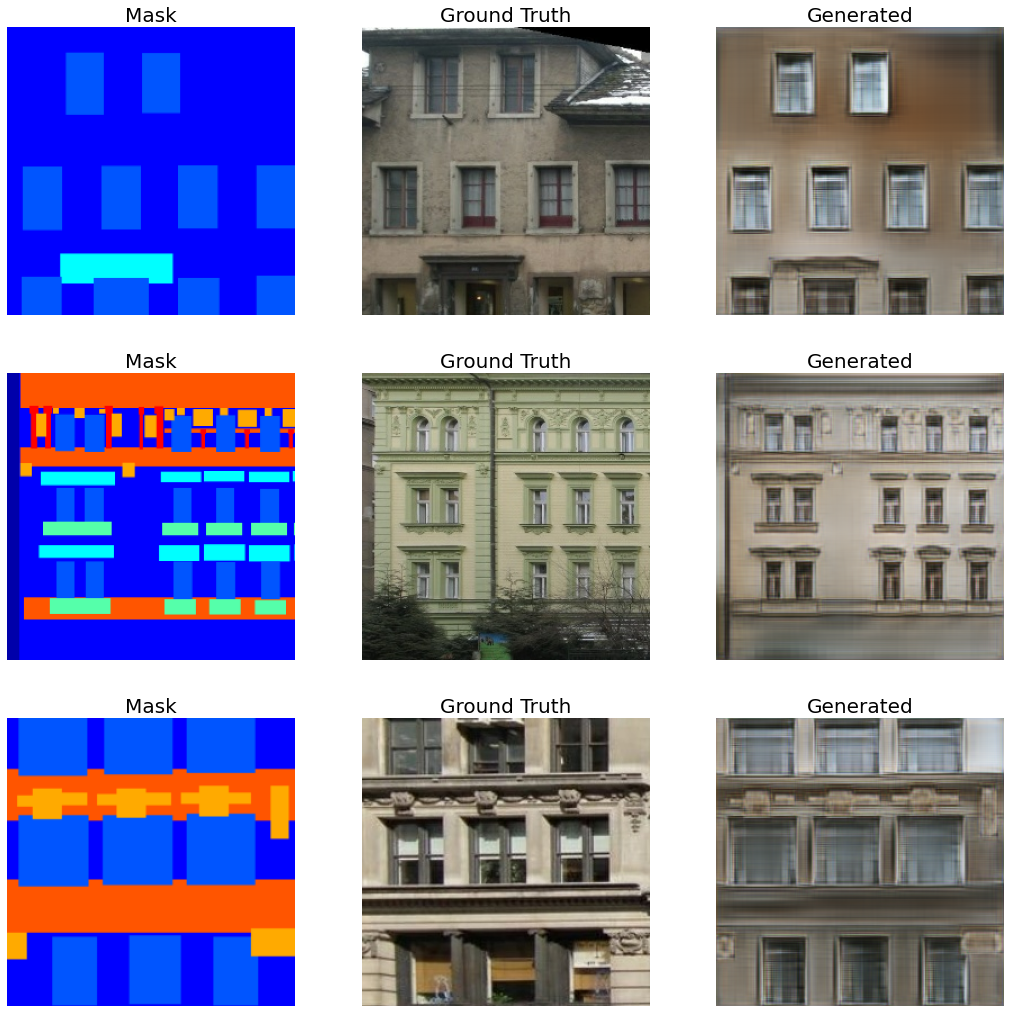

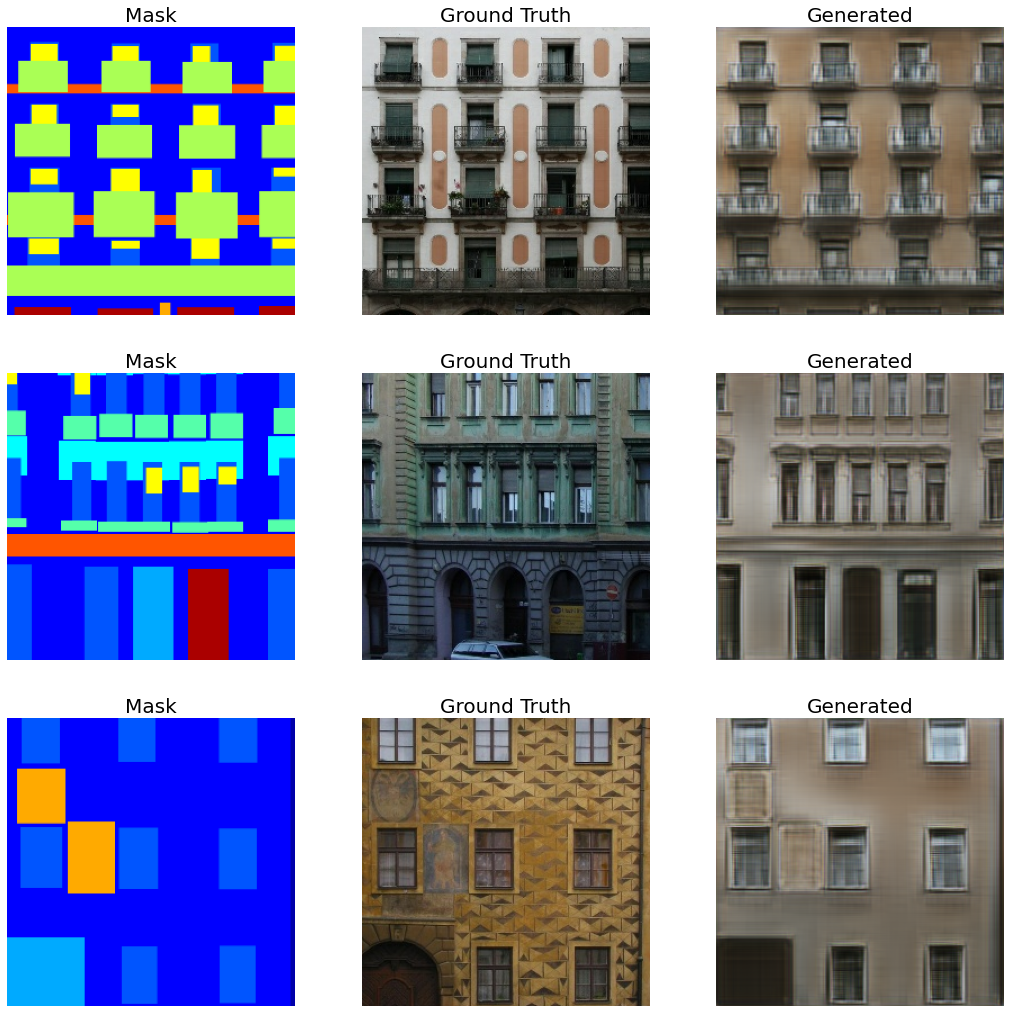

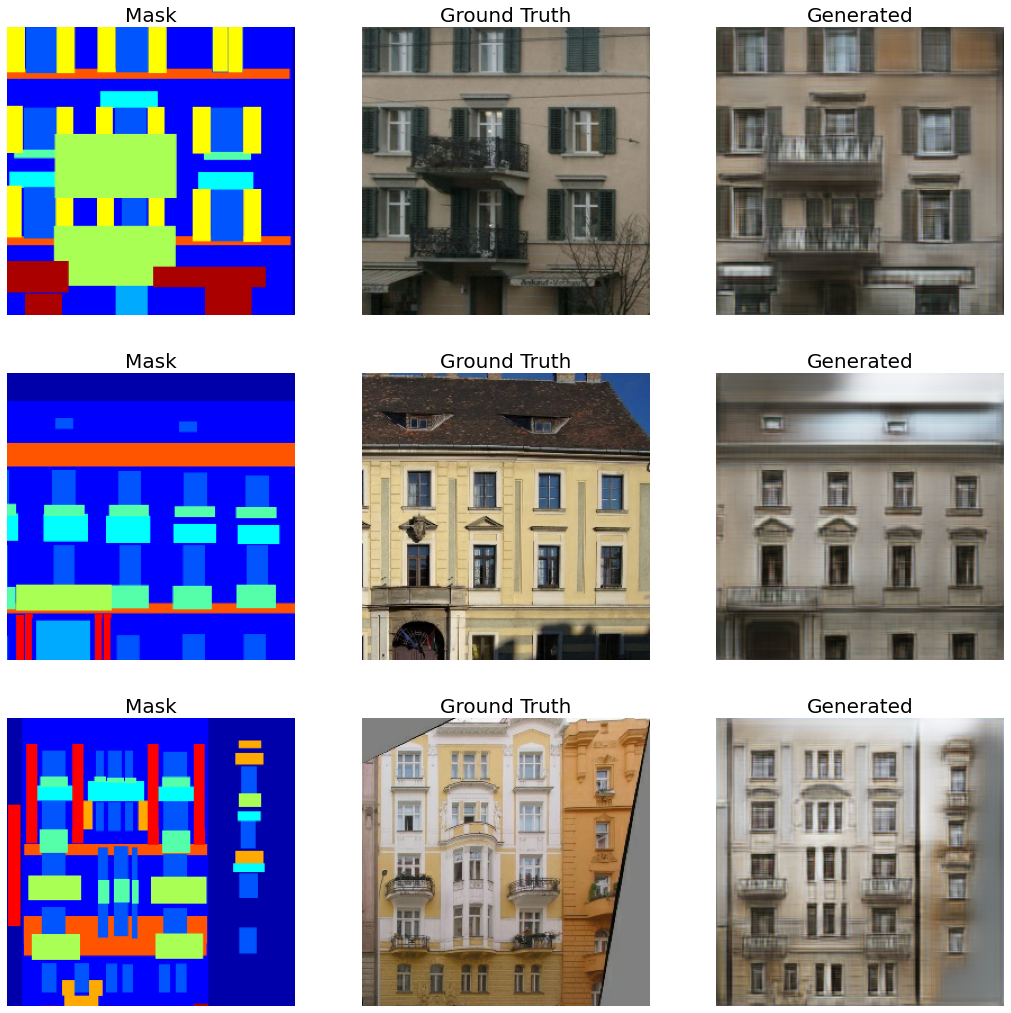

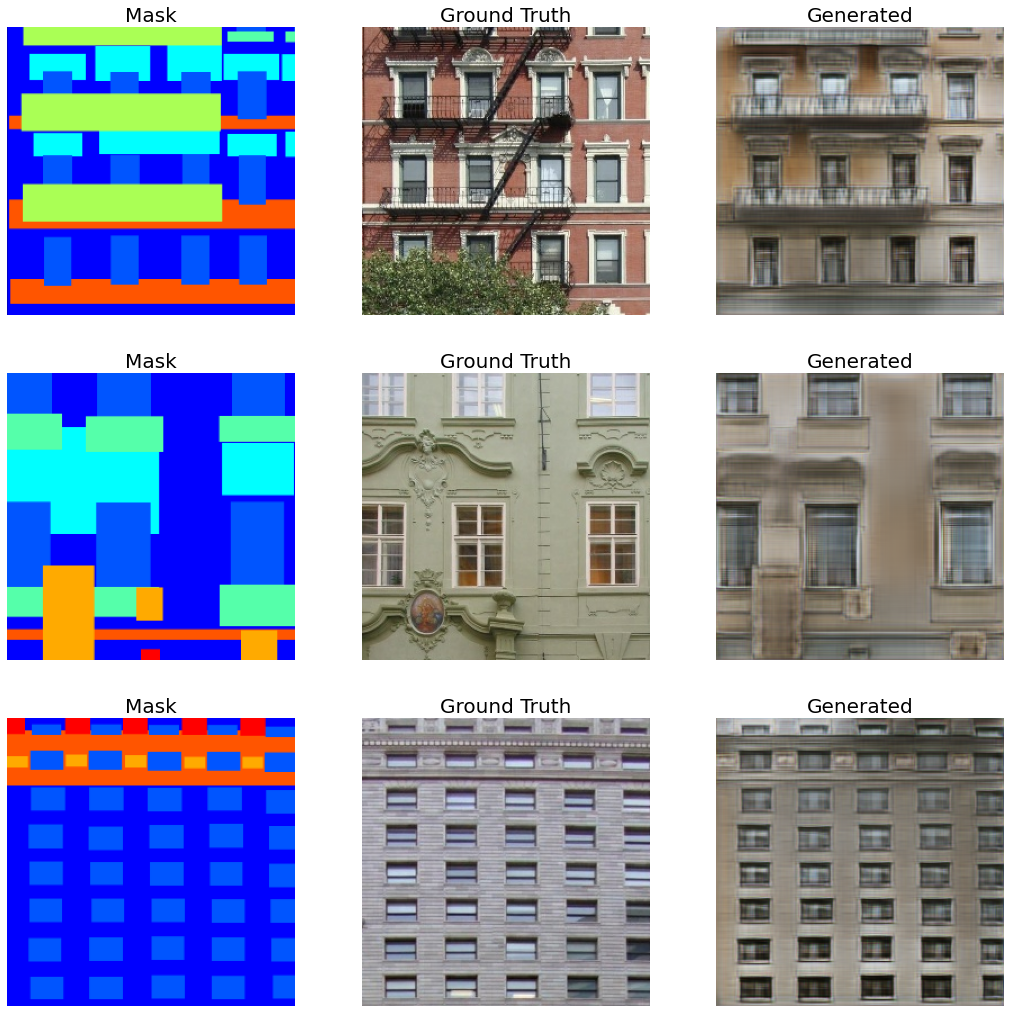

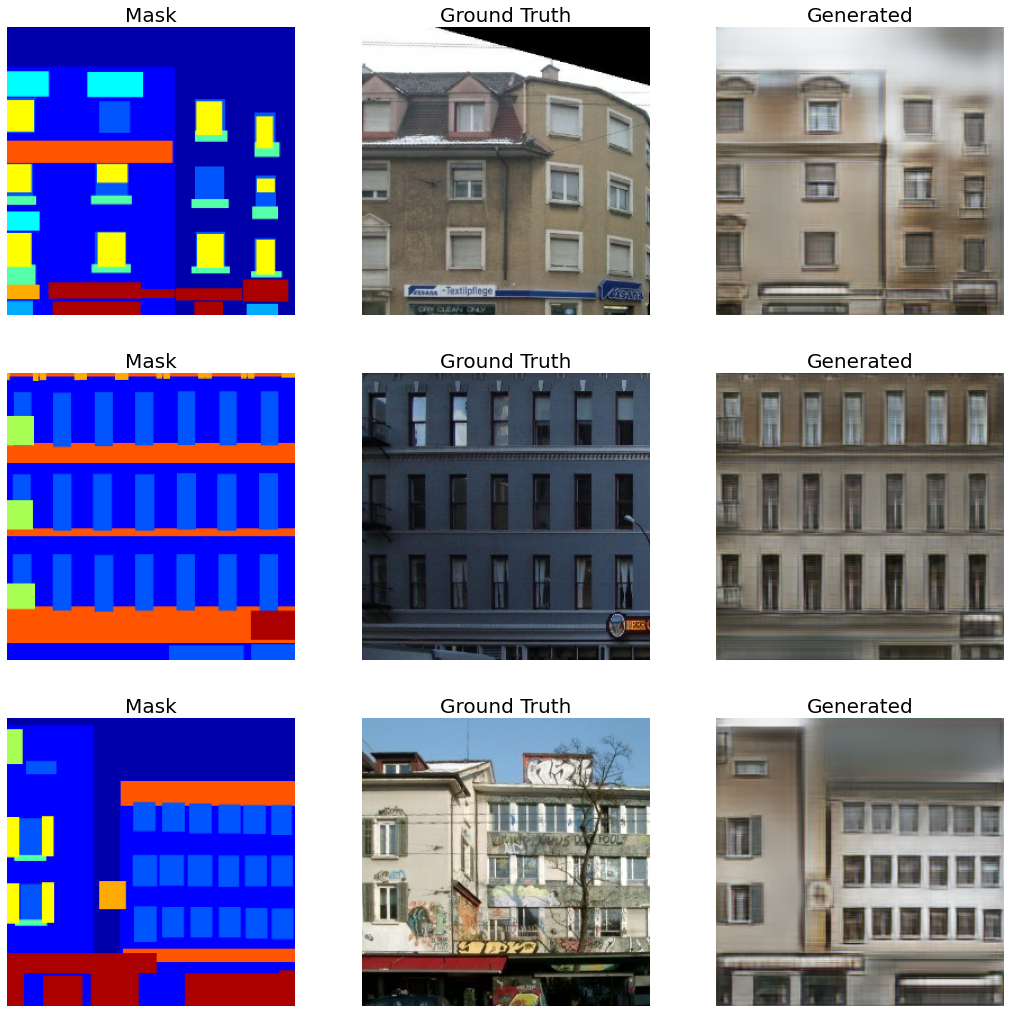

In [9]:
val_iterator = iter(val_dataset)

for _ in range(5):
    val_images = next(val_iterator)
    # Sample latent from a normal distribution.
    latent_vector = tf.random.normal(
        shape=(gaugan_model.batch_size, gaugan_model.latent_dim), mean=0.0, stddev=2.0
    )
    # Generate fake images.
    fake_images = gaugan_model.predict([latent_vector, val_images[2]])

    real_images = val_images
    grid_row = min(fake_images.shape[0], 3)
    grid_col = 3
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col * 6, grid_row * 6))
    for row in range(grid_row):
        ax = axarr if grid_row == 1 else axarr[row]
        ax[0].imshow((real_images[0][row] + 1) / 2)
        ax[0].axis("off")
        ax[0].set_title("Mask", fontsize=20)
        ax[1].imshow((real_images[1][row] + 1) / 2)
        ax[1].axis("off")
        ax[1].set_title("Ground Truth", fontsize=20)
        ax[2].imshow((fake_images[row] + 1) / 2)
        ax[2].axis("off")
        ax[2].set_title("Generated", fontsize=20)
    plt.show()

For more details please refer to our blog post: [GauGAN for conditional image generation](https://keras.io/examples/generative/gaugan/).